In [1]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE= 256
BATCH_SIZE= 16
CHANNELS=3
EPOCHS=40

Load the data into tensorflow dataset

In [3]:
dataset= tf.keras.preprocessing.image_dataset_from_directory(
"PlantVillage",
shuffle=True,
image_size=(IMAGE_SIZE,IMAGE_SIZE),
batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

135

In [6]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(16, 256, 256, 3)
[0 0 0 0 0 0 0 2 1 1 1 1 0 1 1 0]


In [7]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[164. 156. 169.]
  [160. 152. 165.]
  [156. 148. 161.]
  ...
  [139. 133. 143.]
  [124. 118. 128.]
  [158. 152. 162.]]

 [[155. 147. 160.]
  [154. 146. 159.]
  [154. 146. 159.]
  ...
  [168. 162. 172.]
  [170. 164. 174.]
  [155. 149. 159.]]

 [[150. 142. 155.]
  [151. 143. 156.]
  [153. 145. 158.]
  ...
  [134. 128. 138.]
  [155. 149. 159.]
  [166. 160. 170.]]

 ...

 [[137. 125. 137.]
  [137. 125. 137.]
  [137. 125. 137.]
  ...
  [152. 145. 153.]
  [136. 129. 137.]
  [140. 133. 141.]]

 [[136. 124. 136.]
  [136. 124. 136.]
  [135. 123. 135.]
  ...
  [139. 132. 140.]
  [131. 124. 132.]
  [125. 118. 126.]]

 [[136. 124. 136.]
  [135. 123. 135.]
  [134. 122. 134.]
  ...
  [127. 120. 128.]
  [156. 149. 157.]
  [157. 150. 158.]]], shape=(256, 256, 3), dtype=float32)


In [8]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].shape)

(256, 256, 3)


In [9]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[171. 168. 179.]
  [167. 164. 175.]
  [167. 164. 175.]
  ...
  [110. 107. 118.]
  [142. 139. 150.]
  [135. 132. 143.]]

 [[178. 175. 186.]
  [172. 169. 180.]
  [169. 166. 177.]
  ...
  [108. 105. 116.]
  [127. 124. 135.]
  [120. 117. 128.]]

 [[182. 179. 190.]
  [176. 173. 184.]
  [171. 168. 179.]
  ...
  [142. 139. 150.]
  [142. 139. 150.]
  [124. 121. 132.]]

 ...

 [[194. 189. 195.]
  [200. 195. 201.]
  [207. 202. 208.]
  ...
  [165. 160. 166.]
  [171. 166. 172.]
  [179. 174. 180.]]

 [[195. 190. 196.]
  [195. 190. 196.]
  [199. 194. 200.]
  ...
  [172. 167. 173.]
  [147. 142. 148.]
  [153. 148. 154.]]

 [[215. 210. 216.]
  [199. 194. 200.]
  [186. 181. 187.]
  ...
  [157. 152. 158.]
  [163. 158. 164.]
  [162. 157. 163.]]]


visualize the img

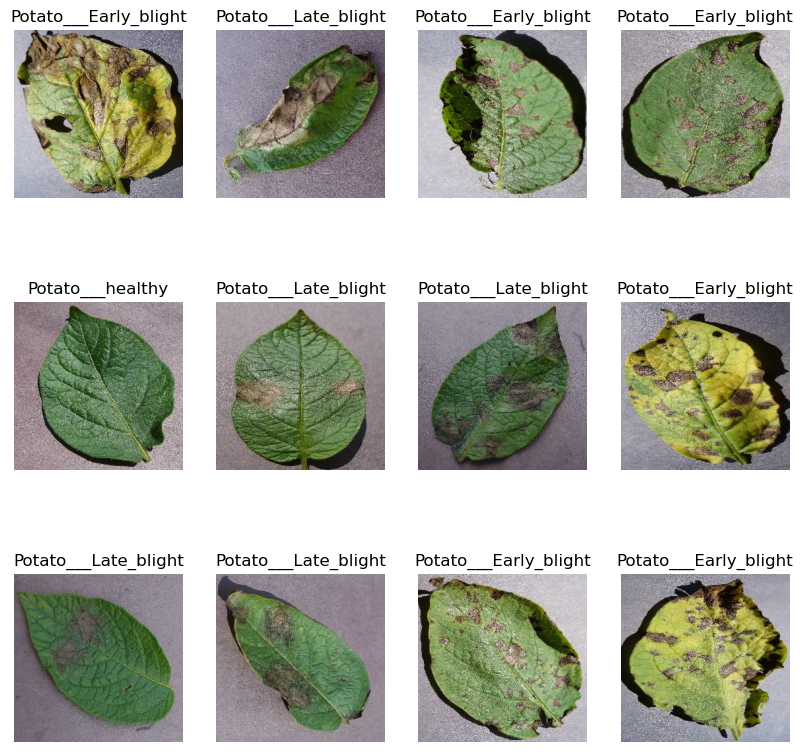

In [10]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

Split the dataset

In [11]:
len(dataset)

135

80%-->training
20%--->10%- validation, 10%-test

In [12]:
train_size=0.8
len(dataset)*train_size

108.0

In [13]:
training_dataset= dataset.take(108) ##same as slicing operator arr[:54],1st 54
len(training_dataset)

108

In [14]:
testing_dataset= dataset.skip(108) ##same as arr[54:], 54 onwards
len(testing_dataset)

27

In [15]:
val_size=0.1
len(dataset)*val_size

13.5

In [16]:
validation_dataset= testing_dataset.take(13)
len(validation_dataset)

13

In [17]:
testing_dataset=testing_dataset.skip(13)
len(testing_dataset)

14

In [18]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    
    if shuffle:
        ds= ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split * ds_size)
    val_size=int(val_split * ds_size)
    
    training_dataset= ds.take(train_size)
    
    validation_dataset= ds.skip(train_size).take(val_size)
    testing_dataset= ds.skip(train_size).skip(val_size)
    
    return training_dataset, validation_dataset, testing_dataset

In [19]:
training_dataset, validation_dataset, testing_dataset= get_dataset_partitions_tf(dataset)

In [20]:
len(validation_dataset)

13

In [21]:
len(testing_dataset)

14

In [22]:
len(training_dataset)

108

read img from disk and in the next iteration if you need sme img, it will keep this in memory and this inc performance

In [23]:
training_dataset= training_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_dataset= validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
testing_dataset= testing_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Pre-processing

Resizing(what if there is an img, during prediction whose size is not 256*256, Rescaling(numpy array of img was 0-255 RGB scale...divide the no. by 255 so as to get no. b/n  0-1, Data augmentation(rotate the imgs and provide these new training samples so that the model becomes robust(you provide an img with diff contrast during prediction, model will be able to recognise due to augmentation)

In [24]:
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [25]:
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

CNN - to build model

In [26]:
input_shape= (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE,CHANNELS)
n_classes= 3
model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size= (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),#to normalise the probability of classes
])

model.build(input_shape= input_shape)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

In [28]:
model.compile(
   optimizer='adam',
   loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
   metrics=['accuracy']
)

In [29]:
history= model.fit(
    training_dataset,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_dataset
)

Epoch 1/40
108/108 [==============================] - 192s 1s/step - loss: 0.8454 - accuracy: 0.5191 - val_loss: 0.6041 - val_accuracy: 0.7250
Epoch 2/40
108/108 [==============================] - 124s 1s/step - loss: 0.5677 - accuracy: 0.7263 - val_loss: 0.3644 - val_accuracy: 0.8650
Epoch 3/40
108/108 [==============================] - 125s 1s/step - loss: 0.4560 - accuracy: 0.7946 - val_loss: 0.3111 - val_accuracy: 0.8650
Epoch 4/40
108/108 [==============================] - 126s 1s/step - loss: 0.3397 - accuracy: 0.8501 - val_loss: 0.2337 - val_accuracy: 0.8850
Epoch 5/40
108/108 [==============================] - 126s 1s/step - loss: 0.2690 - accuracy: 0.8900 - val_loss: 0.1614 - val_accuracy: 0.9150
Epoch 6/40
108/108 [==============================] - 124s 1s/step - loss: 0.2307 - accuracy: 0.9103 - val_loss: 0.2124 - val_accuracy: 0.8950
Epoch 7/40
108/108 [==============================] - 124s 1s/step - loss: 0.1945 - accuracy: 0.9311 - val_loss: 0.0919 - val_accuracy: 0.9650

In [30]:
scores= model.evaluate(testing_dataset)

14/14 [==============================] - 19s 470ms/step - loss: 0.0119 - accuracy: 0.9955


In [31]:
scores #python list , first parameter=loss, second parameter=accuracy

[0.011892824433743954, 0.9955357313156128]

In [32]:
history

In [33]:
history.params


{'verbose': 1, 'epochs': 40, 'steps': 108}

In [34]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [35]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

plot the training vs testing accuracy

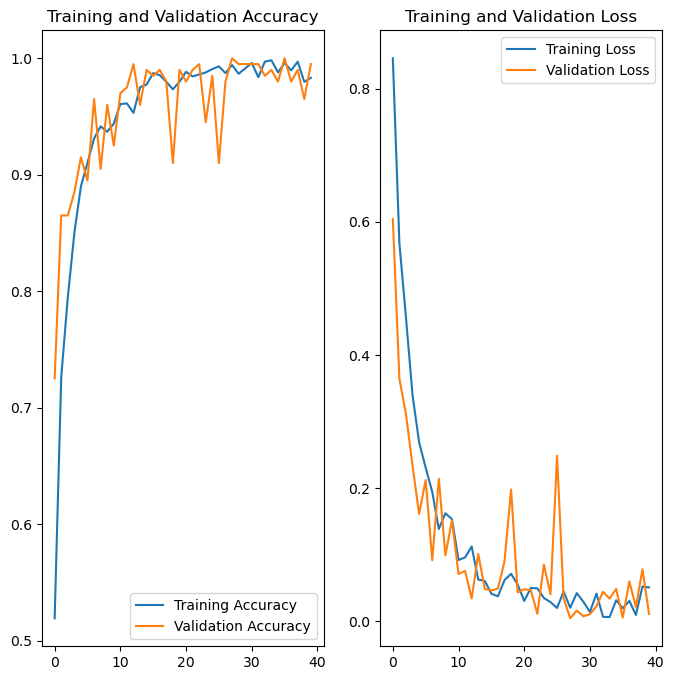

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 5s 5s/step
[9.9992788e-01 7.2172814e-05 3.7203715e-16]
0
prediction label: Potato___Early_blight


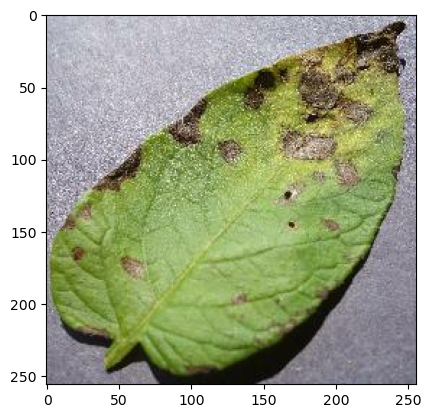

In [37]:
import numpy as np
for images_batch, labels_batch in testing_dataset.take(1):
    first_image= images_batch[0].numpy().astype('uint8')
    first_label= labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction= model.predict(images_batch)
    print(batch_prediction[0]) #highest probability will be the class, use argmax
    print(np.argmax(batch_prediction[0])) #convert to class name
    print("prediction label:" ,class_names[np.argmax(batch_prediction[0])])

In [38]:
def predict(model, img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array,0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100* (np.max(predictions[0])),2)
    return predicted_class, confidence

1/1 [==============================] - 0s 264ms/step


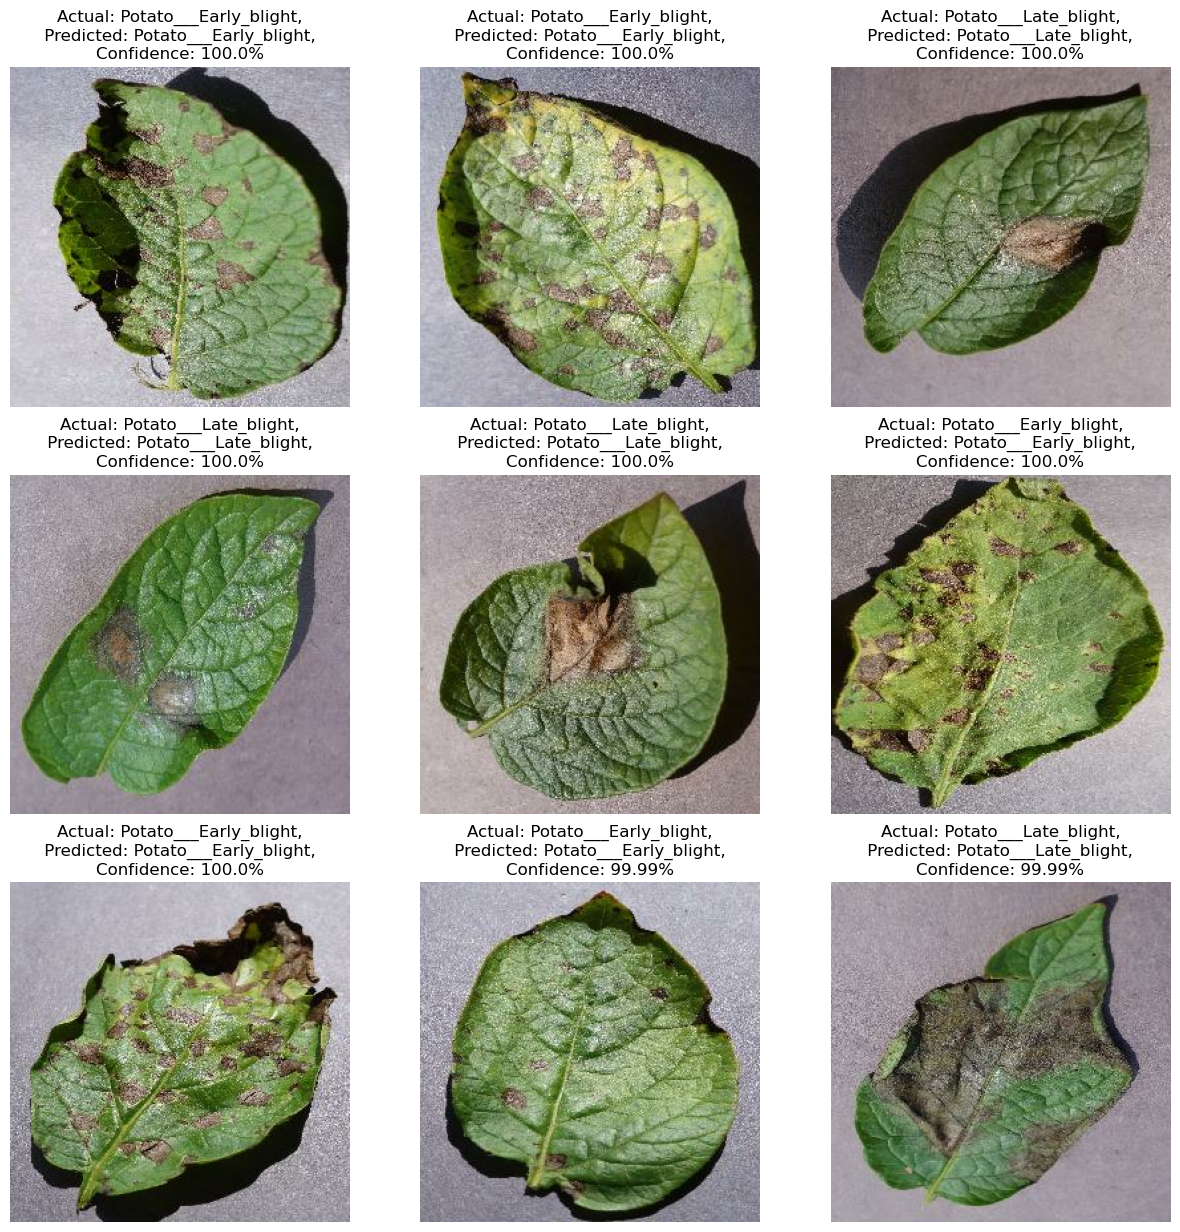

In [39]:
plt.figure(figsize=(15,15))
for images, labels in testing_dataset.take(1):
    for i in range(9):
        ax=plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        
        predicted_class,confidence=predict(model, images[i].numpy())
        actual_class= class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}, \nConfidence: {confidence}%")
        
        plt.axis("off")
    

In [40]:

model.save("../potatoes.h5")
